# EXPLORATORY ANALYSIS
## 1 - CODICE

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
WORKINGDIRECTORY = os.path.join(r'C:\Users','Cristian Bergamo','PycharmProjects','conte') #this folder is the main folder of the project
print(WORKINGDIRECTORY)

C:\Users\Cristian Bergamo\PycharmProjects\conte


In [13]:
train_users = pd.read_csv(os.path.join(WORKINGDIRECTORY, 'data', 'train_users.csv'))

In [14]:
def histogram(x_ticks, x1, x2, labelX1, labelX2, labelXAxis, labelYAxis, w, title, path):
    r1 = np.arange(len(x1))
    r2 = [x + w for x in r1]

    plt.bar(r1, x1, width=w, label=labelX1)
    plt.bar(r2, x2, width=w, label=labelX2)

    plt.title(title)
    plt.xlabel(labelXAxis, fontweight='bold')
    plt.ylabel(labelYAxis, fontweight='bold')
    len_max = max([len(str(tick)) for tick in x_ticks])
    if len_max > 3:
        rotation = 45
    else:
        rotation = 0
    plt.xticks([r + w for r in range(len(r1))], x_ticks, rotation=rotation)
    plt.legend()
    plt.show()
    plt.clf()
    plt.close()

    return


def stackedBarChart(x_ticks, Ys, width, title, x_label, y_label, path, data_labels):
    colors = np.random.randint(255, size=(len(Ys), 3)) / 255

    N = len(x_ticks)
    ind = np.arange(N)
    plt.bar(ind, Ys[0], width, label=data_labels[0], color=colors[0])
    bottom = Ys[0]
    for i, y in enumerate(Ys[1:]):
        i += 1
        plt.bar(ind, y, width, bottom=bottom, label=data_labels[i], color=colors[i])
        bottom += y

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(ind, x_ticks)
    plt.legend(bbox_to_anchor=(1.15, 1),ncol = 3)
    plt.show(path)
    plt.clf()
    plt.close()

    return


def mapDevices(sessions):
    device_mapping = {'Windows Desktop': 'Desktop',
                      '-unknown-': 'other',
                      'Mac Desktop': 'Desktop',
                      'Android Phone': 'Phone',
                      'iPhone': 'Phone',
                      'iPad Tablet': 'Tablet',
                      'Android App Unknown Phone/Tablet': 'unknown',
                      'Linux Desktop': 'Desktop',
                      'Tablet': 'Tablet',
                      'Chromebook': 'Desktop',
                      'Blackberry': 'Phone',
                      'iPodtouch': 'Phone',
                      'Windows Phone': 'Phone',
                      'Opera Phone': 'Phone'
                      }
    sessions.loc[sessions.index, ['device_type']] = sessions['device_type'].map(device_mapping)

    return sessions



def ageBucketAnalysis():
    age_gender_bkts = pd.read_csv(os.path.join(WORKINGDIRECTORY, 'data', 'age_gender_bkts.csv'))
    for age_bucket in np.unique(age_gender_bkts['age_bucket']):
        ab_filtered = age_gender_bkts[age_gender_bkts['age_bucket'] == age_bucket].sort_values('country_destination')
        males = ab_filtered[ab_filtered['gender'] == 'male']
        females = ab_filtered[ab_filtered['gender'] == 'female']
        x = sorted(np.unique(ab_filtered.country_destination))
        y_males = males['population_in_thousands']
        y_females = females['population_in_thousands']

        histogram(x, y_males, y_females, 'males', 'females', 'Country', 'Pop (*1000)', 0.3,
                  'Age bucket %s divided in genders and countries' % age_bucket,
                  os.path.join(WORKINGDIRECTORY, 'exploratoryAnalysis', 'age_bucket_%s.png' % age_bucket))

    return


def sessionsUsers(boolean_booked=0, users=None):
    sessions = pd.read_csv(os.path.join(WORKINGDIRECTORY, 'data', 'sessions.csv'))
    if boolean_booked:
        users.loc[users.index,'booked'] = np.array(users['country_destination'] != 'NDF').astype(int)
    sessions_users = sessions[sessions['user_id'].isin(users['id'])]
    sessions_users.loc[sessions_users.index,'min_elapsed'] = sessions_users['secs_elapsed'] / 60
    sessions_users.drop(['secs_elapsed'], axis=1, inplace=True)
    sessions_users = sessions_users.merge(users[['id', ['country_destination', 'booked'][boolean_booked]]],
                                          left_on='user_id', right_on='id').drop('id', axis=1)

    return sessions_users


def sessionsAnalysisBooked(col_to_analyze='action_type', sessions=None):
    sessions.loc[sessions.index,'count'] = 1

    ''' Analisi durata e quantità azioni'''
    for j, val in enumerate(['min_elapsed', 'count']):
        pivot = sessions[['user_id', col_to_analyze, val, 'booked']].pivot_table(
            index=['user_id', col_to_analyze, 'booked'],
            values=val,
            aggfunc='sum').reset_index()
        x = sorted(np.unique(pivot[col_to_analyze]))
        pivot_0 = pivot[pivot['booked'] == 0]
        pivot_0_pivot = pivot_0.pivot_table(index=col_to_analyze, values=val, aggfunc='median')
        pivot_1 = pivot[pivot['booked'] == 1]
        pivot_1_pivot = pivot_1.pivot_table(index=col_to_analyze, values=val, aggfunc='median')
        histogram(x, pivot_0_pivot[val], pivot_1_pivot[val], 'Not booked', 'Booked', col_to_analyze, '%s' % val, 0.3,
                  '%s - Mediana %s tipologie' % (
                      col_to_analyze, ('del tempo totale speso dall\' utente sulle singole',
                                       'delle azioni totali per utente per singole')[j]),
                  os.path.join(WORKINGDIRECTORY, 'exploratoryAnalysis',
                               '%s - Mediana %s tipologie.png' % (
                                   col_to_analyze, ('del tempo totale speso dall\' utente sull singole',
                                                    'delle azioni totali per utente per singole')[j])))

    ''' Analisi eterogeneità azioni'''
    tab1 = sessions[sessions['booked'] == 0].pivot_table(index='user_id', values=col_to_analyze,
                                                         aggfunc=lambda x: len(np.unique(x.astype(str))))
    tab2 = sessions[sessions['booked'] == 1].pivot_table(index='user_id', values=col_to_analyze,
                                                         aggfunc=lambda x: len(np.unique(x.astype(str))))
    x1 = np.array(np.unique(tab1[col_to_analyze], return_counts=True)).astype(float)
    x1[1] = x1[1] / x1[1].sum()
    x2 = np.array(np.unique(tab2[col_to_analyze], return_counts=True)).astype(float)
    x2[1] = x2[1] / x2[1].sum()

    histogram(x1[0], x1[1], x2[1], 'Not Booked', 'Booked', 'N° different %s' % col_to_analyze, 'relative frequency',
              0.3,
              'Booked/Not booked analysis of %s heterogeneity' % col_to_analyze,
              os.path.join(WORKINGDIRECTORY, 'exploratoryAnalysis',
                           'Heterogeneity of %s in booked vs not booked.png' % col_to_analyze))

    return


def sessionsAnalysisDestination(col_to_analyze='action_type', sessions_train=None):
    sessions_train.loc[sessions_train.index,'count'] = 1
    values = {}

    ''' Analisi durata e quantità '''
    for action in sorted(sessions_train[col_to_analyze].astype(str).unique()):
        values[action] = 0
    for j, val in enumerate(['min_elapsed', 'count']):
        for country in sessions_train['country_destination'].unique():
            country_values = values.copy()
            df = sessions_train[sessions_train['country_destination'] == country]
            pivot = df[['user_id', col_to_analyze, 'min_elapsed', 'count']].pivot_table(
                index=['user_id', col_to_analyze],
                values=val,
                aggfunc='sum').reset_index()
            pivot_ = pivot.pivot_table(index=col_to_analyze, values=val, aggfunc='median')
            for i in pivot_.index:
                country_values[i] = pivot_.loc[i][0]
            plt.plot(pd.Series(country_values).sort_index().values, linestyle='--', marker='_', label=country)

        xticks = sorted(sessions_train[col_to_analyze].astype(str).unique())
        plt.xticks(range(len(xticks)), xticks, rotation=45)
        plt.title(['Tempo totale speso sulle singole %s, diviso per Paese di destinazione' % col_to_analyze,
                   'Numero totale %s, diviso per Paese di destinazione' % col_to_analyze][j])
        plt.xlabel(col_to_analyze, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.15, 1))
        plt.ylabel(['Median tempo speso', 'Mediana numero tipologie'][j], fontweight='bold')
        plt.show()
        plt.clf()
        plt.close()

    ''' Analisi Eterogeneità '''
    for country in sessions_train['country_destination'].unique():
        df = sessions_train[sessions_train['country_destination'] == country]
        tab = df.pivot_table(index='user_id', values=col_to_analyze, aggfunc=lambda x: len(np.unique(x.astype(str))))
        x = np.array(np.unique(tab[col_to_analyze], return_counts=True)).astype(float)
        x[1] = x[1] / x[1].sum()
        plt.plot(x[0], x[1], linestyle='--', marker='_', label=country)
    plt.xlabel(col_to_analyze, fontweight='bold')
    plt.ylabel('Frequenza relativa', fontweight='bold')
    plt.title('Eterogeneità %s paese per paese' % col_to_analyze)
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()
    plt.clf()
    plt.close()
    return


def trainUsersAnalysis(users=None, columns_to_analyze=[]):
    for column in columns_to_analyze:
        if column == 'language':
            users = users[users['language'] != 'en']
        users_pivot = users.pivot_table(index=['country_destination'], columns=column, values='id', aggfunc='count')
        users_pivot.fillna(0, inplace=True)
        columns = users_pivot.columns
        users_pivot['totale'] = users_pivot.sum(axis=1)
        for col in columns:
            users_pivot.loc[:, col] /= users_pivot.iloc[:, -1]
        users_pivot.drop('totale', axis=1, inplace=True)

        x_ticks = list(users_pivot.index)
        Ys = [np.array(users_pivot.loc[:, col]) for col in columns]
        path = os.path.join(WORKINGDIRECTORY, 'exploratoryAnalysis',
                            'stacked bar chart - relative frequency of %s per country.png' % column)
        stackedBarChart(x_ticks, Ys, 0.4, 'Analysis of %s per country' % column, 'Country', 'relative frequency', path,
                        columns)

    return

def datetimeAnalysis(users=None):
    users.loc[:, 'timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'].astype(str).str[:8],format = '%Y%m%d')
    users.loc[:, 'date_account_created'] = pd.to_datetime(users['date_account_created'],format = '%Y-%m-%d' )
    users.insert(1, 'time_gap_after_creation',
                 (users.timestamp_first_active - users.date_account_created).dt.days)

    for year in range(2010,2015):

        data = users[users.timestamp_first_active.dt.year == year].time_gap_after_creation
        plt.scatter(range(len(data)),data)
        plt.title('timegap first_active - date_creation for year ' + str(year))
        plt.show()
        plt.clf()
        plt.close()


## 2 - AGE AND GENDER ANALYSIS
### Analisi del file "age_gender_bkts.csv"

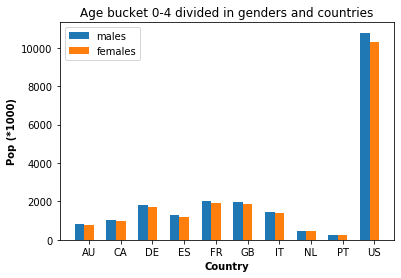

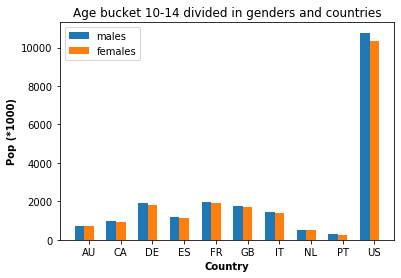

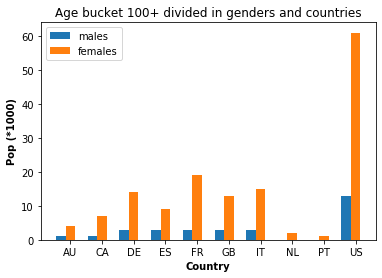

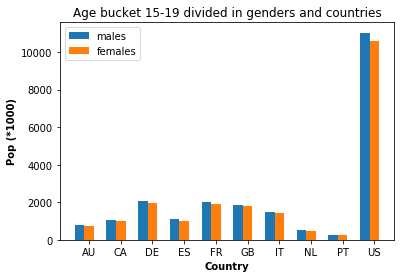

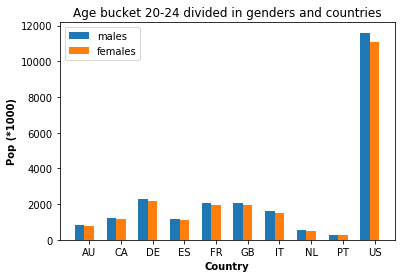

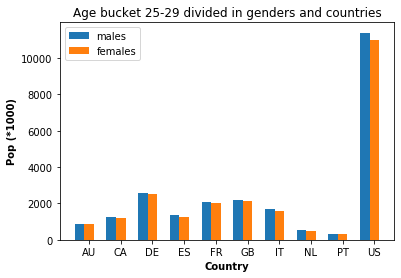

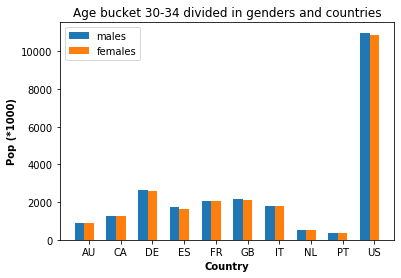

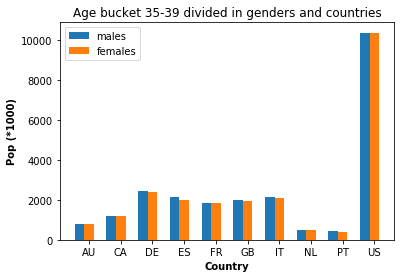

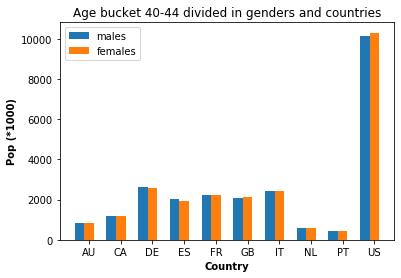

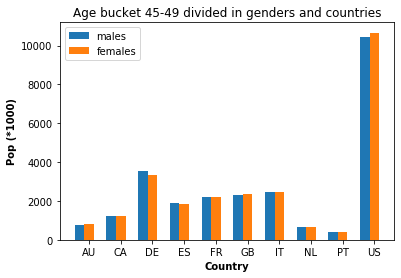

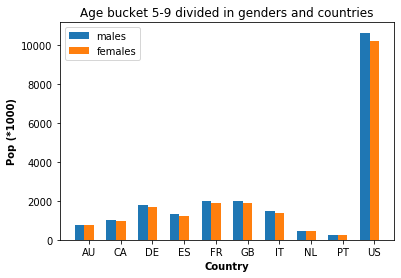

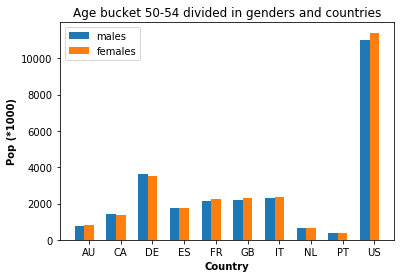

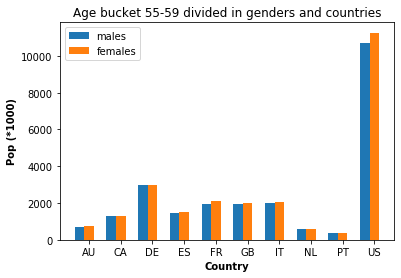

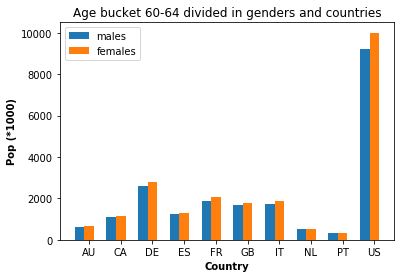

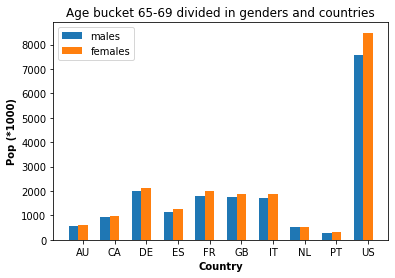

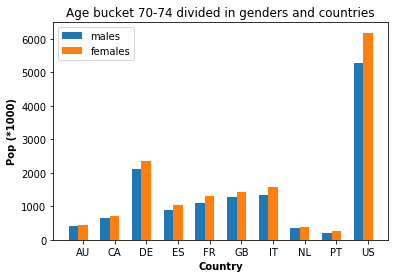

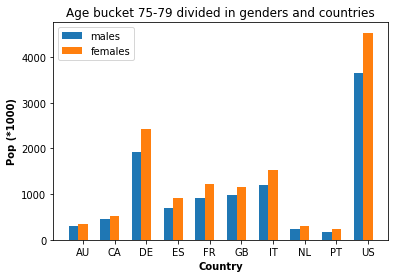

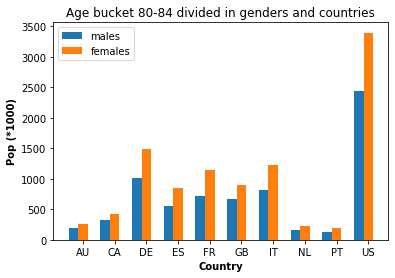

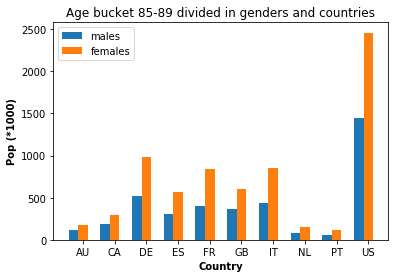

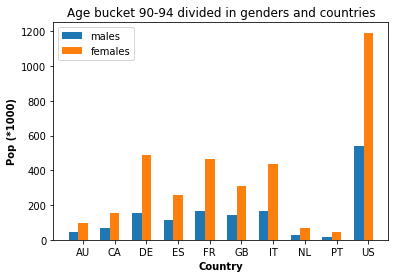

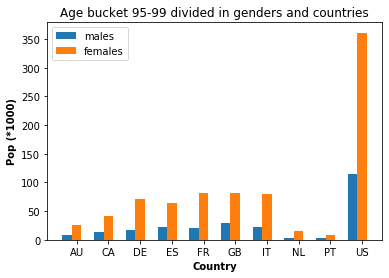

In [6]:
ageBucketAnalysis()

## 3 - SESSIONS ANALYSIS
### Analisi del file "sessions.csv"

#### 3.1 -  Analisi del collegamento tra azioni e propensione a prenotare

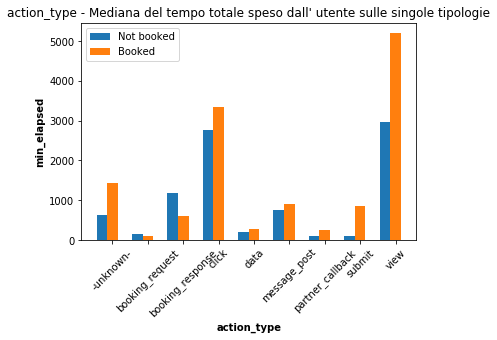

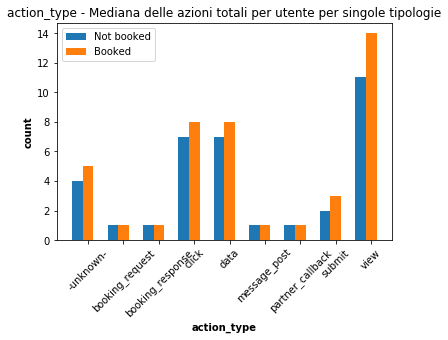

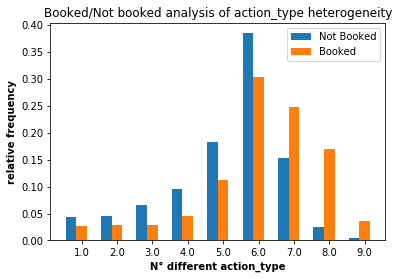

In [11]:
sessionsAnalysisBooked(col_to_analyze='action_type', sessions=sessionsUsers(boolean_booked=1, users=train_users))

#### 3.2 -  Analisi del collegamento tra azioni e Paese di destinazione

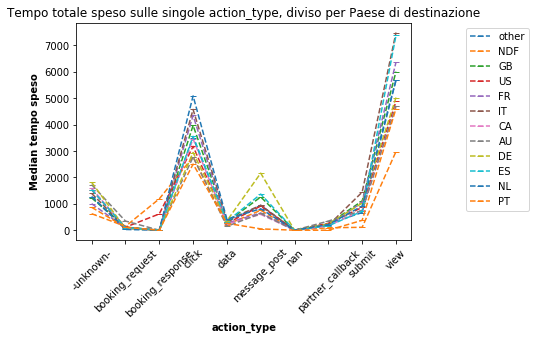

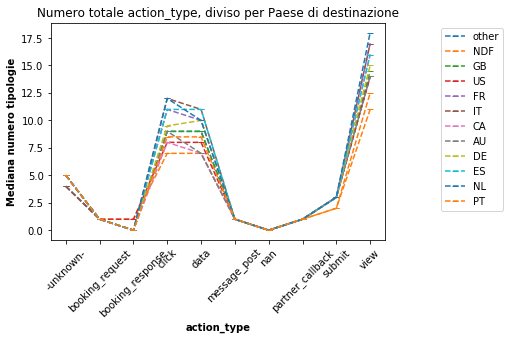

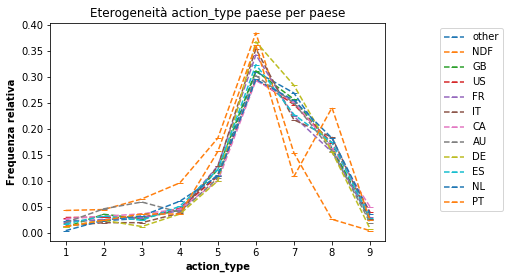

In [12]:
sessionsAnalysisDestination('action_type', sessionsUsers(boolean_booked=0, users=train_users))

#### 3.3 - Analisi del collegamento tra tipo di device e propensione a prenotare

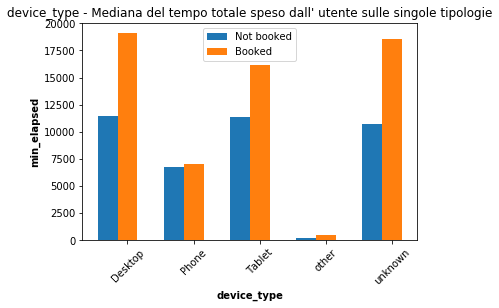

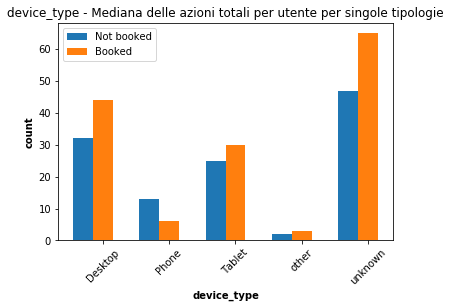

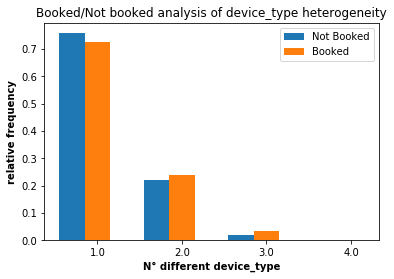

In [13]:
sessionsAnalysisBooked('device_type', mapDevices(sessionsUsers(boolean_booked=1, users=train_users)))

#### 3.4 - Analisi del collegamento tra tipo di device e Paese di destinazione

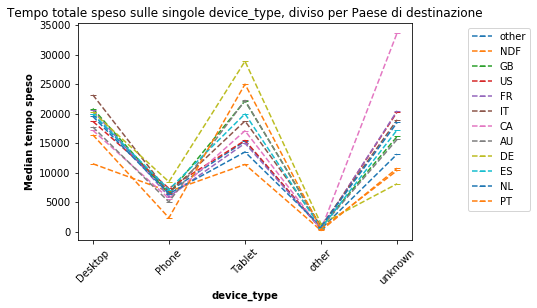

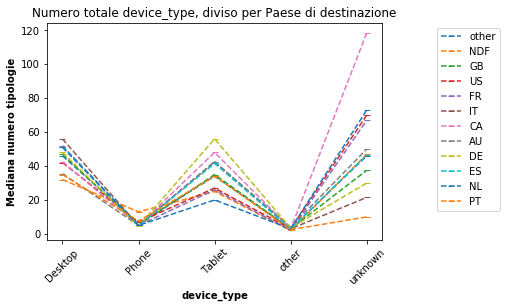

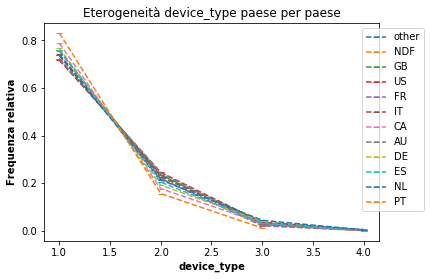

In [14]:
sessionsAnalysisDestination('device_type', mapDevices(sessionsUsers(boolean_booked=0, users=train_users)))

## 4 - USERS DATA Analysis
### ANALISI DEL FILE "train_users.csv"

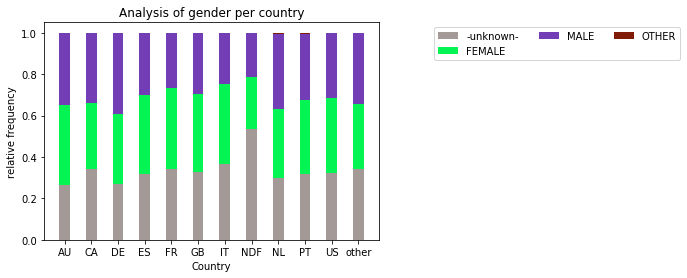

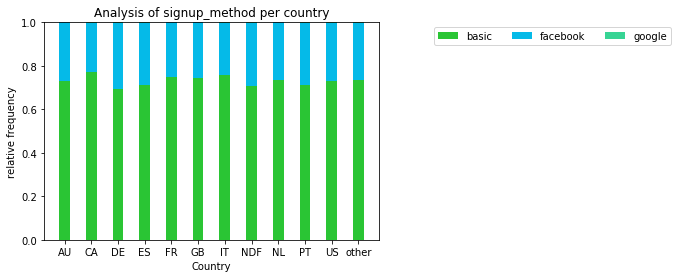

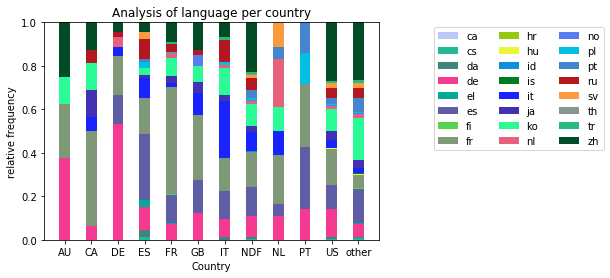

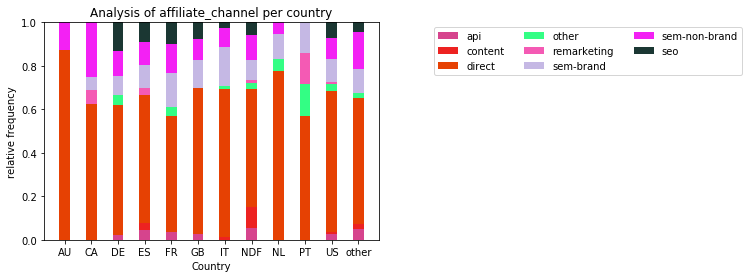

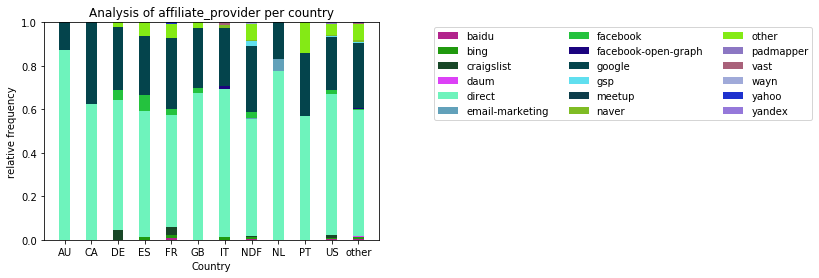

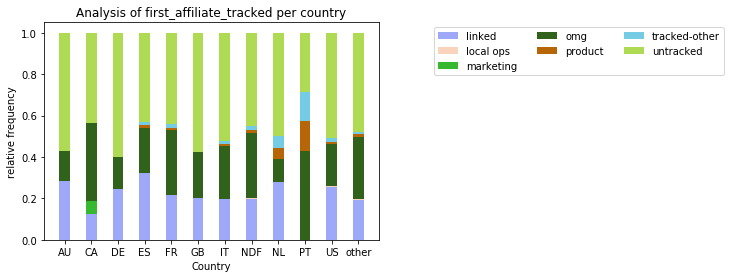

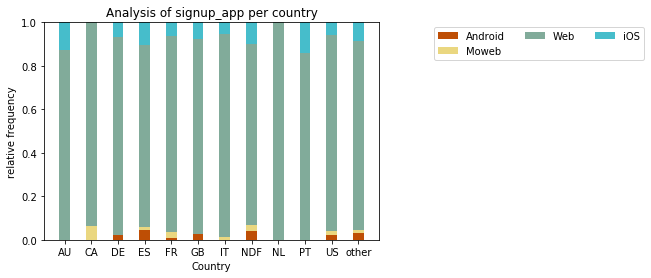

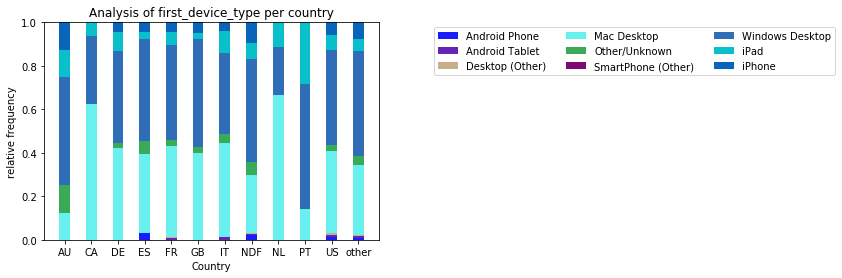

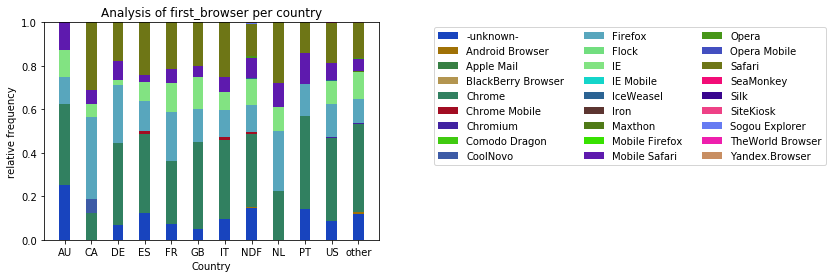

In [15]:
trainUsersAnalysis(users=train_users,
                   columns_to_analyze=['gender', 'signup_method', 'language', 'affiliate_channel',
                                       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
                                       'first_device_type', 'first_browser'])

## 5 - Time data analysis
### Analisi della distanza temporale primo utilizzo e data creazione

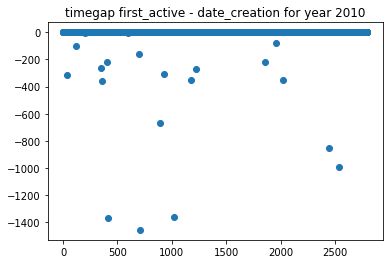

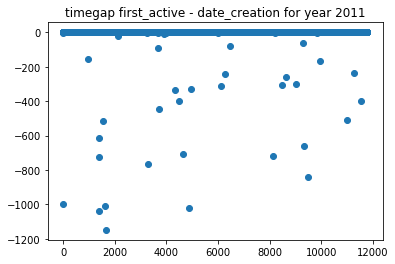

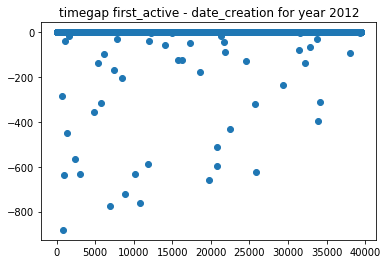

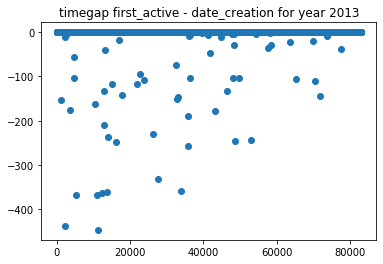

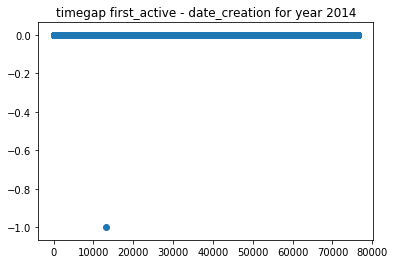

In [15]:
datetimeAnalysis(train_users)